In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from time import sleep
from sklearn.model_selection import train_test_split

In [2]:
DATASET_FOLDER_PATH = '/Users/aref/dvs-dataset/DvsGesture'
DATA_SET_TRAIL = 'train'

nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 100
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 32

In [3]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [4]:
# Loading file:
trail_file = 'trials_to_%s.txt' % DATA_SET_TRAIL
file_list = []
with open(os.path.join(DATASET_FOLDER_PATH, trail_file), 'r') as f:
    for line in f.readlines():
        aedat_file = line.strip()
        if not line:
            continue
        csv_file = aedat_file.replace('.aedat', '_labels.csv')
        file_list.append((
            os.path.join(DATASET_FOLDER_PATH, aedat_file),
            os.path.join(DATASET_FOLDER_PATH, csv_file)
        ))

In [5]:
from reader import read_file_all
from collections import OrderedDict

file_name_set = file_list[3] # change this in order to change the sample

print 'reading "%s"' % file_name_set[0]
event_list = read_file_all(file_name_set[0])

label_began_time = None
event_labels = OrderedDict()
with open(file_name_set[1], 'r') as f:
    for line in f.readlines():
        label, start, end = line.strip().split(',')
        print '%5s\t%15s\t%15s' % (label, start, end)
        try:
            label = int(label)
            start = int(start)
            end = int(end)
        except ValueError:
            continue
        if label_began_time is None:
            label_began_time = start
            
        event_labels[start] = 0
        event_labels[end] = label
        
def get_label(timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0

def get_label_text(timestamp):
    return gesture_mapping[get_label(timestamp)]

# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}

reading "/Users/aref/dvs-dataset/DvsGesture/user01_led.aedat"
loading dataset...
done!
class	 startTime_usec	   endTime_usec
    1	       48486443	       53269496
    2	       54965479	       61654131
    3	       62416370	       67828271
    4	       70801005	       78747352
    5	       79566760	       86941427
    6	       89799825	       98108236
    7	       98279740	      104168041
    8	      104911224	      112419283
    8	      112667011	      118745871
    9	      119774895	      126635051
   10	      128045194	      134905349
   11	      135858149	      142337185


In [7]:
img = np.zeros([nb_image_weight, nb_image_height])

x_train = np.zeros([0, 100, nb_inputs])
y_train = []

max_offset = 8
for offset_c in range(max_offset):
    offset = offset_c * 2
    print 'running offset: %d out of %d' % (offset + 1, max_offset * 2)
    max_time = None
    min_time = None
    begin_time = None
    end_time = None

    prev_label = None
    frame_counter = 0
    offset_counter = offset
    x_frame = np.zeros([1, 100, nb_inputs])
    for e in event_list:
        if e != 'clear':
            img[int(e['y']/2), int(e['x']/2)] = 1 # if e['polarity'] == 1 else 0
            if e['timestamp'] < min_time or min_time is None:
                min_time = e['timestamp']
            if e['timestamp'] > max_time or max_time is None:
                max_time = e['timestamp']
        else:
            if begin_time is None:
                begin_time = min_time
            end_time = max_time
            mean_time = (max_time + min_time)/2
            mean_time = mean_time - begin_time + label_began_time
            label = get_label(mean_time)
            max_time = None
            min_time = None
            if prev_label is None:
                prev_label = label
            elif prev_label != label:
                prev_label = None
                x_frame = np.zeros([1, 100, nb_inputs])
                img = np.zeros([nb_image_weight, nb_image_height])
                frame_counter = 0
                continue
            
            if offset_counter > 0:
                x_frame = np.zeros([1, 100, nb_inputs])
                img = np.zeros([nb_image_weight, nb_image_height])
                offset_counter -= 1
                continue
            
            if frame_counter == 100:
                y_train.append(label)
                x_train = np.append(x_train, x_frame, axis=0)
                x_frame = np.zeros([1, 100, nb_inputs])

                frame_counter = 0
            else:
                x_frame[0, frame_counter, :] = img.flatten()
                frame_counter += 1
            img = np.zeros([nb_image_weight, nb_image_height])

y_train = np.array(y_train)
print x_train.shape
print y_train.shape

running offset: 1 out of 16
running offset: 3 out of 16
running offset: 5 out of 16
running offset: 7 out of 16
running offset: 9 out of 16
running offset: 11 out of 16
running offset: 13 out of 16
running offset: 15 out of 16
(648, 100, 4096)
(648,)


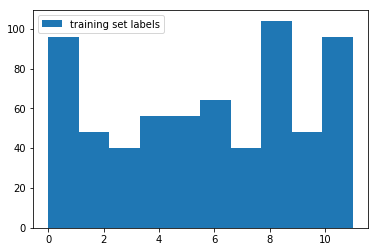

fixing data imbalancement
(balancing to 104)
adding 8 items to class "1"
adding 56 items to class "2"
adding 64 items to class "3"
adding 48 items to class "4"
adding 48 items to class "5"
adding 40 items to class "6"
adding 64 items to class "7"
adding 0 items to class "8"
adding 56 items to class "9"
adding 8 items to class "10"
(1040, 100, 4096)
(1040,)


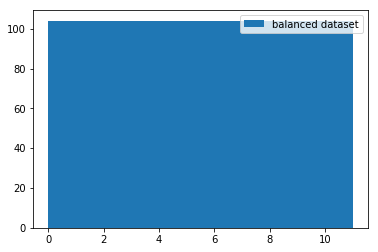

In [8]:
%matplotlib inline


counts, bins = np.histogram(y_train)
plt.hist(bins[:-1], bins, weights=counts, label='training set labels')
plt.legend()
plt.show()

print 'fixing data imbalancement'
max_data_count = max(counts)
print '(balancing to %d)' % max_data_count

to_add_set = max_data_count - counts
for ii in range(len(counts)):
    i = ii + 1
    to_add = to_add_set[ii]
    print 'adding %d items to class "%d"' % (to_add, i)
    
    availables = x_train[y_train == i]
    s = availables[np.random.choice(len(availables), to_add)]
    x_train = np.append(x_train, s, axis=0)
    y_train = np.append(y_train, [i] * to_add, axis=0)

print x_train.shape
print y_train.shape

counts, bins = np.histogram(y_train)
plt.hist(bins[:-1], bins, weights=counts, label='balanced dataset')
plt.legend()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print 'train:'
print x_train.shape
print y_train.shape
print 'test:'
print x_test.shape
print y_test.shape

train:
(936, 100, 4096)
(936,)
test:
(104, 100, 4096)
(104,)


In [45]:
# Show the results
%matplotlib qt

random_index = np.random.randint(x_train.shape[0])

for frame_count in range(x_train.shape[1]):
    img = np.reshape(x_test[random_index, frame_count, :], (nb_image_weight, nb_image_height))
    label = gesture_mapping[y_train[random_index]]
    
    plt.figure(0)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.show()
    plt.title('(%d-%d) Label: %s' % (random_index, frame_count, label))
    plt.pause(0.0001)
    sleep(0.05)
    plt.clf()

<Figure size 864x576 with 0 Axes>

In [11]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [12]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print('init')

init


In [46]:
class SuperSpike(torch.autograd.Function):
    scale = 5.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SuperSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SuperSpike.apply

In [34]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [35]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        max_count = x_train.shape[0] / batch_size
        for counter in range(max_count):
            i = counter*batch_size
            x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
            y_local = torch.from_numpy(y_data[i:i+batch_size])
            
#             print '>>>>>', x_local.shape, y_local.shape
#             print y_local

            output,_ = run_snn(x_local)
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist


In [48]:
print 'x_train shape:', x_train.shape
print 'y_train shape:', y_train.shape
loss_hist = train(x_train, y_train.astype(np.long), lr=2e-4, nb_epochs=5)

x_train shape: (936, 100, 4096)
y_train shape: (936,)
Epoch 1: loss=0.00457
Epoch 2: loss=0.00000
Epoch 3: loss=0.00000
Epoch 4: loss=0.00000
Epoch 5: loss=0.00000


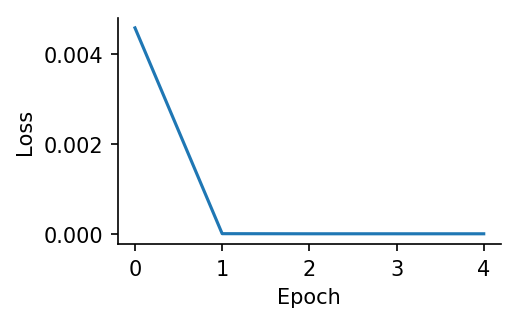

In [49]:
%matplotlib inline
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [50]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    max_count = len(x_data) / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
        y_local = torch.from_numpy(y_data[i:i+batch_size])
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1) # max over time
        _, am = torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local.type(torch.long)==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)


print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train, y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 1.000
Test accuracy: 1.000


In [51]:
file_name_set = file_list[6] # change this in order to change the sample

print 'reading "%s"' % file_name_set[0]
event_list = read_file_all(file_name_set[0])

label_began_time = None
event_labels = OrderedDict()
with open(file_name_set[1], 'r') as f:
    for line in f.readlines():
        label, start, end = line.strip().split(',')
        print '%5s\t%15s\t%15s' % (label, start, end)
        try:
            label = int(label)
            start = int(start)
            end = int(end)
        except ValueError:
            continue
        if label_began_time is None:
            label_began_time = start
            
        event_labels[start] = 0
        event_labels[end] = label
        

img = np.zeros([nb_image_weight, nb_image_height])

x_test2 = np.zeros([0, 100, nb_inputs])
y_test2 = []

max_time = None
min_time = None
begin_time = None
end_time = None

prev_label = None
frame_counter = 0
offset_counter = offset
x_frame = np.zeros([1, 100, nb_inputs])
for e in event_list:
    if e != 'clear':
        img[int(e['y']/2), int(e['x']/2)] = 1 # if e['polarity'] == 1 else 0
        if e['timestamp'] < min_time or min_time is None:
            min_time = e['timestamp']
        if e['timestamp'] > max_time or max_time is None:
            max_time = e['timestamp']
    else:
        if begin_time is None:
            begin_time = min_time
        end_time = max_time
        mean_time = (max_time + min_time)/2
        mean_time = mean_time - begin_time + label_began_time
        label = get_label(mean_time)
        max_time = None
        min_time = None
        if prev_label is None:
            prev_label = label
        elif prev_label != label:
            prev_label = None
            x_frame = np.zeros([1, 100, nb_inputs])
            img = np.zeros([nb_image_weight, nb_image_height])
            frame_counter = 0
            continue

        if frame_counter == 100:
            y_test2.append(label)
            x_test2 = np.append(x_test2, x_frame, axis=0)
            x_frame = np.zeros([1, 100, nb_inputs])

            frame_counter = 0
        else:
            x_frame[0, frame_counter, :] = img.flatten()
            frame_counter += 1
        img = np.zeros([nb_image_weight, nb_image_height])

y_test2 = np.array(y_test2)
print x_test2.shape
print y_test2.shape

print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test2, y_test2)))

reading "/Users/aref/dvs-dataset/DvsGesture/user02_fluorescent_led.aedat"
loading dataset...
done!
class	 startTime_usec	   endTime_usec
    1	       41338207	       45921981
    2	       50981549	       56515452
    3	       59124292	       64757015
    4	       68690039	       75686473
    5	       77801214	       83275826
    6	       85430095	       91062818
    7	       92821808	       98355711
    8	       99976354	      106537982
    8	      107723818	      113514652
    9	      116360659	      122151494
   10	      124957973	      130195417
   11	      132567089	      139069425
(86, 100, 4096)
(86,)
Test accuracy: 0.328


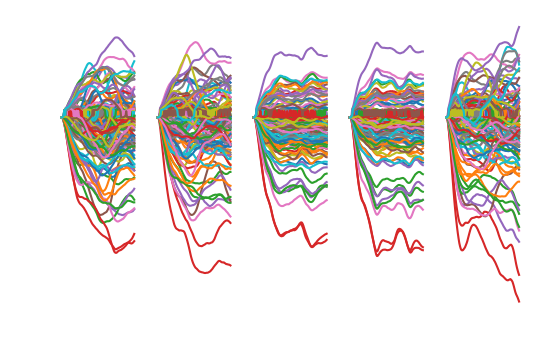

In [40]:
def plot_voltage_traces(mem, spk=None, dim=(1,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

def get_mini_batch(x_data, y_data, shuffle=False):
    max_count = x_data.shape[0] / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = x_data[i:i+batch_size, :, :]
        y_local = y_data[i:i+batch_size]
        return x_local, y_local

x_batch, y_batch = get_mini_batch(x_train, y_train)
output, other_recordings = run_snn(torch.from_numpy(x_batch).type(dtype))
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

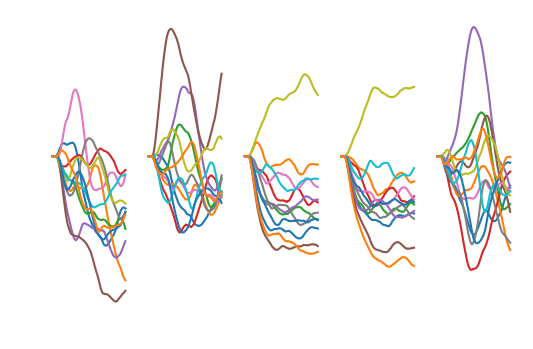

In [41]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

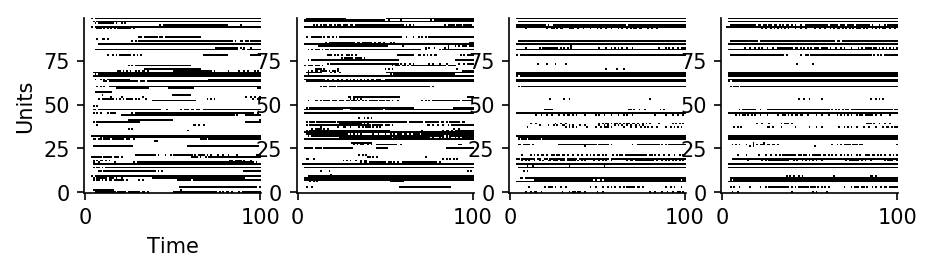

In [42]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()